# GA

### AFElSamak_2015_AffinityPropagationClustering_GA
###### AHussain_2017_GA_ModifiedCycleCrossover => Cycle Crossover (CX)
###### ARiazi_2019_GA_Double‐Chromosome => (X) IDK
###### CWTsai_2014_High-PerformanceGA => Common Genes Detection, Compression (Good)
###### JWang_2016_Multi-offspringGA (medium-scale) => (?already) Multi-Offspring
###### SDDao_2016_EffectiveGA (Large-Scale TSP) => Initial Chromosome Strategy (Maybe Good)
###### YDeng_2015_ImprovedGA_InitialPopulationStrategy => K-Means Clustering (...)
###### YWang_2014_HybridGA_TwoLocalOptStrategies => (X) 4 vertices 3 lines inequality

Common Genes Detection & Compression, Initial Chromosome Strategy, K-Means Cluster

In [1]:
# package list
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import time

In [2]:
# Plot Settings
PLOT_MODE = True # Draw Route
PLT_INTERVAL = 100 # Draw Route every 100 iterations
plt.ion()

## Data Loading

In [3]:
def fileloader():
    with open(file_path, "r") as file:
        file_str = file.readlines()
    
    coord_start_idx = 8
    for line in range(2,len(file_str)-1):
        if 'NODE_COORD_SECTION' in file_str[line]:
            coord_start_idx = line + 1
    # Get the coordinates of cities
    coord_str = file_str[coord_start_idx:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        items = item.split()
        coord_list[idx, 0], coord_list[idx, 1] = float(items[1]), float(items[2])

    return coord_list

## GA_Large

In [4]:
# Global Variables
FIRST_IDX = 0
# GA
# initial pool size
INITIAL_POOL_SIZE = 4
# maximum pool size
MAXIMUM_POOL_SIZE = 50
MAX_ITERATION = 100000

## Initialize

In [5]:
def initialize_greedy(coord_list, path_map):
    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
    path = np.zeros(cnt_cities + 1, dtype=np.int32)
    path[0], path[-1] = FIRST_IDX, FIRST_IDX

    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[FIRST_IDX] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        start_idx = path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        path[i] = nearest_city

    return path

# effective initialization
def initialize_effective(x_coord_sorted, y_coord_sorted, first_idx):
    cnt_cities = len(coord_list)
    path = np.zeros(cnt_cities + 1, dtype=np.int32)
    path[0], path[-1] = FIRST_IDX, FIRST_IDX
    path[1] = first_idx
    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[FIRST_IDX] = False
    cities_tovisit[first_idx] = False
    for i in range(2, cnt_cities-1):
        
        if path[i]!=0:
            continue
        
        x_idx = np.where(x_coord_sorted == path[i-1])[0][0]
        y_idx = np.where(y_coord_sorted == path[i-1])[0][0]
        
        for j in range(1, cnt_cities):
            
            x_segment = np.concatenate([
                x_coord_sorted[max(1, x_idx-j):x_idx], 
                x_coord_sorted[x_idx+1:min(x_idx+j+1,cnt_cities+1)]
            ])
            y_segment = np.concatenate([
                y_coord_sorted[max(1, y_idx-j):y_idx], 
                y_coord_sorted[y_idx+1:min(y_idx+j+1,cnt_cities+1)]
            ])
            
            common_cities = []
            
            if cities_tovisit[x_segment[0]]:
                if x_segment[0] in y_segment:
                    common_cities.append(x_segment[0])
                    
            if cities_tovisit[x_segment[-1]]:
                if x_segment[-1] in y_segment:
                    common_cities.append(x_segment[-1])
                    
            if cities_tovisit[y_segment[0]]:
                if y_segment[0] in x_segment:
                    common_cities.append(y_segment[0])
                    
            if cities_tovisit[y_segment[-1]]:
                if y_segment[-1] in x_segment:
                    common_cities.append(y_segment[-1])
            
            common_cities = list(set(common_cities))
            common_count = len(common_cities)
            
            if common_count > 0:
                common_cities = np.array(common_cities)
                cities_tovisit[common_cities] = False
                np.random.shuffle(common_cities)
                path[i:i+common_count] = common_cities
                break
                
    path[-2] = np.where(cities_tovisit)[0][0]
    return path

def initialize_random(coord_list):
    cnt_cities = len(coord_list)
    path = np.zeros(cnt_cities + 1, dtype=np.int32)

    path[0], path[-1] = FIRST_IDX, FIRST_IDX

    # city indices without first city index
    cities_tovisit = np.delete(np.arange(cnt_cities), FIRST_IDX)
    cities_random = np.random.permutation(cities_tovisit)
    path[1:-1] = cities_random

    return path

def path_cost(path_map, path, subpath_dict={}):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        # expand compressed subpath
        while path[i+1]<-1:
            path = np.concatenate([path[:i+1], subpath_dict[path[i+1]], path[i+2:]])
        cost_arr[i] = path_map[path[i], path[i+1]]
    return cost_arr

In [6]:
def initialization(coord_list):
    cnt_cities = len(coord_list)
    path_pool = np.zeros((INITIAL_POOL_SIZE, cnt_cities + 1), dtype=np.int32)
    pool_cost = np.zeros(INITIAL_POOL_SIZE)
    
    path_map = euclidean_distances(coord_list, coord_list)
    
    # greedy path initialization
    path_pool[0, :] = initialize_greedy(coord_list, path_map)
    pool_cost[0] = path_cost(path_map, path_pool[0, :]).sum()

    print('Path {} is initialized'.format(0))

    # effective path initialization
    x_coord_sorted = np.argsort(coord_list[:,0])
    y_coord_sorted = np.argsort(coord_list[:,1])
    argsorted = np.argsort(path_map[FIRST_IDX, :])
    for i in range(1, INITIAL_POOL_SIZE-1):
        path_pool[i, :] = initialize_effective(x_coord_sorted, y_coord_sorted, argsorted[i])
        pool_cost[i] = path_cost(path_map, path_pool[i, :]).sum()
#         _, path_pool[i, :] = initialize_random(coord_list, FIRST_IDX)
#         path_pool[i, :], pool_cost[i] = sa(path_map, path_pool[i, :], coord_list)
        print('Path {} is initialized'.format(i))
    
    # random path initialization
    path_pool[INITIAL_POOL_SIZE-1, :] = initialize_random(coord_list)
    pool_cost[INITIAL_POOL_SIZE-1] = path_cost(path_map, path_pool[INITIAL_POOL_SIZE-1, :]).sum()
    print('Path {} is initialized'.format(INITIAL_POOL_SIZE-1))
    
    return path_pool, pool_cost, path_map

## Selection

In [7]:
def selection(pool_cost, tournament_size, sel_size):
    # tournament selection
    sel_idx = np.random.choice(pool_cost.shape[0], tournament_size, replace=False)
    sel_cost = pool_cost[sel_idx]
    best_idx = sel_idx[np.argsort(sel_cost)][:sel_size]
    return best_idx

## Crossover

In [8]:
# ox crossover
def oxcrossover(path1, path2):
    cnt_cities = len(path1) - 1
    # Select two indices of crossover points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    
    # Initialize child path 1~4
    child_path_1 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_2 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_3 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_4 = np.zeros(cnt_cities + 1, dtype=np.int32)
    
    child_path_1[0], child_path_1[-1] = -1, -1
    child_path_2[0], child_path_2[-1] = -1, -1
    child_path_3[0], child_path_3[-1] = -1, -1
    child_path_4[0], child_path_4[-1] = -1, -1
    
    # Copy the path between crossover points
    child_path_1[sel_idx[0]:sel_idx[1]] = path1[sel_idx[0]:sel_idx[1]]
    child_path_2[sel_idx[0]:sel_idx[1]] = path2[sel_idx[0]:sel_idx[1]]
    
    # Copy the rest of the path from another path
    path2_idx = np.where(np.isin(path2, child_path_1) == False)[0]
    child_path_1[np.where(child_path_1 == 0)[0]] = path2[path2_idx]
    child_path_1[0], child_path_1[-1] = FIRST_IDX, FIRST_IDX

    path1_idx = np.where(np.isin(path1, child_path_2) == False)[0]
    child_path_2[np.where(child_path_2 == 0)[0]] = path1[path1_idx]
    child_path_2[0], child_path_2[-1] = FIRST_IDX, FIRST_IDX

    
    # Reverse the subpath and save to child path 3 4
    child_path_3 = child_path_1.copy()
    child_path_3[sel_idx[0]:sel_idx[1]] = np.flip(child_path_3[sel_idx[0]:sel_idx[1]])
    child_path_4 = child_path_2.copy()
    child_path_4[sel_idx[0]:sel_idx[1]] = np.flip(child_path_4[sel_idx[0]:sel_idx[1]])
    
    return np.array([child_path_1, child_path_2, child_path_3, child_path_4])

In [9]:
# pmx crossover
def pmxcrossover(path1, path2):
    cnt_cities = len(path1) - 1
    # Select two indices of crossover points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))

    # Initialize child paths 1~4
    child_path_1 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_2 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_3 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_4 = np.zeros(cnt_cities + 1, dtype=np.int32)
    
    child_path_1[0], child_path_1[-1] = -1, -1
    child_path_2[0], child_path_2[-1] = -1, -1
    child_path_3[0], child_path_3[-1] = -1, -1
    child_path_4[0], child_path_4[-1] = -1, -1
    
    # Copy the path between crossover points
    child_path_1[sel_idx[0]:sel_idx[1]] = path1[sel_idx[0]:sel_idx[1]]
    child_path_2[sel_idx[0]:sel_idx[1]] = path2[sel_idx[0]:sel_idx[1]]
    
    # Partially map cities in subpath
    del_list = []
    part_map = {c1:c2 for c1,c2 in zip(path1[sel_idx[0]:sel_idx[1]], path2[sel_idx[0]:sel_idx[1]])}
    part_map_r = {c2:c1 for c1,c2 in part_map.items()}
    for c1 in path1[sel_idx[0]:sel_idx[1]]:
        if c1 not in part_map_r.keys():
            while part_map[c1] in part_map.keys():
                part_map[c1]=part_map[part_map[c1]]
        else:
            del_list.append(c1)
    for c in del_list:
        del part_map[c]

    # Make a replaced path for the partially mapped cities
    path2_replaced = path2.copy()
    path1_replaced = path1.copy()
    for c1, c2 in part_map.items():
        path2_replaced[np.where(path2==c1)[0]] = c2
        path1_replaced[np.where(path1==c2)[0]] = c1
    
    # Copy the rest of the path from the replaced path
    child_path_1[:sel_idx[0]], child_path_1[sel_idx[1]:] = path2_replaced[:sel_idx[0]], path2_replaced[sel_idx[1]:]
    child_path_2[:sel_idx[0]], child_path_2[sel_idx[1]:] = path1_replaced[:sel_idx[0]], path1_replaced[sel_idx[1]:]
    
    # Reverse the subpath and save to child path 3 4
    child_path_3 = child_path_1.copy()
    child_path_3[sel_idx[0]:sel_idx[1]] = np.flip(child_path_3[sel_idx[0]:sel_idx[1]])
    child_path_4 = child_path_2.copy()
    child_path_4[sel_idx[0]:sel_idx[1]] = np.flip(child_path_4[sel_idx[0]:sel_idx[1]])
    
    return np.array([child_path_1, child_path_2, child_path_3, child_path_4])

## Mutation

In [10]:
# 2-opt mutation
def mutation_2opt(path):
    cnt_cities = len(path)
    child_path = path.copy()
    
    # Select two indices of mutation points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    
    # Swap the path between mutation points
    child_path[sel_idx[0]:sel_idx[1]] = np.flip(child_path[sel_idx[0]:sel_idx[1]])

    return child_path

In [11]:
# single point mutation
def mutation_singlepoint(path):
    cnt_cities = len(path)
    child_path = np.zeros(cnt_cities, dtype=np.int32)
    
    # Select single index of mutation point
    sel_idx = np.random.choice(np.arange(2, cnt_cities-1), 1)[0]
    
    # Swap two subpaths divided by single mutation point
    child_path[1:cnt_cities-sel_idx] = path[sel_idx:-1]
    child_path[cnt_cities-sel_idx:-1] = path[1:sel_idx]
    
    return child_path

In [12]:
# three-point mutation
def mutation_threepoint(path):
    cnt_cities = len(path)
    child_path = path.copy()
    
    # Select three indices of mutation points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities-2), 3))
    
    # Swap the subpaths
    child_path[sel_idx[0]:sel_idx[0]+sel_idx[2]-sel_idx[1]], child_path[sel_idx[0]+sel_idx[2]-sel_idx[1]:sel_idx[2]] = path[sel_idx[1]:sel_idx[2]], path[sel_idx[0]:sel_idx[1]]
    
    return child_path

## Common Subpath Compression

In [13]:
# common subpath compression
def common_subpath_compression(path_pool, subpath_dict):
    sub_start_idx = -1
    for idx in range(1, path_pool.shape[1]-1):
        if idx>=path_pool.shape[1]-1:
            break
            
        if np.min(path_pool[:, idx])==np.max(path_pool[:, idx]):
            if sub_start_idx == -1:
                sub_start_idx = idx
                dict_key = -len(subpath_dict)-2
                
        else:
            if sub_start_idx >= 0:
                if idx - sub_start_idx > 1:
                
                    sub_path = path_pool[0, sub_start_idx:idx]

                    path_pool = np.concatenate([
                        path_pool[:, :sub_start_idx], 
                        np.full((path_pool.shape[0],1), fill_value=dict_key), 
                        path_pool[:, idx:]
                    ], axis=1)

                    subpath_dict[dict_key] = sub_path
                
                sub_start_idx = -1
                
    if sub_start_idx >= 0 and sub_start_idx < path_pool.shape[1]-2:
        
        sub_path = path_pool[0, sub_start_idx:-1]
        
        path_pool = np.concatenate([
            path_pool[:, :sub_start_idx], 
            np.full((path_pool.shape[0],1), fill_value=dict_key), 
            path_pool[:, -1:]
        ], axis=1)
        
        subpath_dict[dict_key] = sub_path
    
    return path_pool, subpath_dict

In [14]:
# expand compressed subpath
def subpath_expand(path, subpath_dict, n_cities):
    for idx in range(1, n_cities):
        while path[idx]<0:
            path = np.concatenate([path[:idx], subpath_dict[path[idx]], path[idx+1:]])
    return path

## GA

In [15]:
# genetic algorithm
def ga(coord_list):
    ga_start_time = time.time()
    best_cost = np.Inf
    print('Start Genetic Algorithm')
    print('Initialize the population')
    path_pool, pool_cost, path_map = initialization(coord_list)
    # common subpath dictionary
    subpath_dict = dict()
    print('Start the evolution')
    for i in range(MAX_ITERATION):
        
        # check timeout
        if time.time() - ga_start_time > 58:
            break
        
        if (i+1) % 1000 == 0:
            print('Iteration {}'.format(i + 1))
        
        # initial population
        if len(pool_cost)==INITIAL_POOL_SIZE:
            child_ox_list = oxcrossover(path_pool[0], path_pool[1])[:2]
            cost_ox_list = []
            for child in child_ox_list:
                cost_ox_list.append(path_cost(path_map, child).sum())
                
            child_pmx_list = pmxcrossover(path_pool[0], path_pool[1])[:2]
            cost_pmx_list = []
            for child in child_pmx_list:
                cost_pmx_list.append(path_cost(path_map, child).sum())
            
            child_mut_swap = mutation_2opt(path_pool[-1])
            cost_mut_swap = path_cost(path_map, child_mut_swap).sum()
            
            child_mut_singlepoint = mutation_singlepoint(path_pool[-1])
            cost_mut_singlepoint = path_cost(path_map, child_mut_singlepoint).sum()
            
            child_mut_threepoint = mutation_threepoint(path_pool[-1])
            cost_mut_threepoint = path_cost(path_map, child_mut_threepoint).sum()
            
            path_pool = np.concatenate([
                path_pool, child_ox_list, child_pmx_list, 
                np.array([child_mut_swap, child_mut_singlepoint, child_mut_threepoint])
            ], axis=0)
            pool_cost = np.concatenate([
                pool_cost, cost_ox_list, cost_pmx_list, [cost_mut_swap, cost_mut_singlepoint, cost_mut_threepoint]
            ])
            
            cur_idx = np.argmin(pool_cost)
            cur_path = path_pool[cur_idx]
            cur_cost = pool_cost[cur_idx]
        
        # until maximum pool size reached
        elif len(pool_cost)<MAXIMUM_POOL_SIZE:
            sel_idx = selection(pool_cost, len(pool_cost)//2, sel_size=5)
            
            child_ox_list = oxcrossover(path_pool[sel_idx[0]], path_pool[sel_idx[2]])[:2]
            cost_ox_list = []
            for child in child_ox_list:
                cost_ox_list.append(path_cost(path_map, child).sum())
                
            child_pmx_list = pmxcrossover(path_pool[sel_idx[1]], path_pool[sel_idx[3]])[:2]
            cost_pmx_list = []
            for child in child_pmx_list:
                cost_pmx_list.append(path_cost(path_map, child).sum())
            
            child_mut_swap = mutation_2opt(path_pool[sel_idx[2]])
            cost_mut_swap = path_cost(path_map, child_mut_swap).sum()
            
            child_mut_singlepoint = mutation_singlepoint(path_pool[sel_idx[3]])
            cost_mut_singlepoint = path_cost(path_map, child_mut_singlepoint).sum()
            
            child_mut_threepoint = mutation_threepoint(path_pool[sel_idx[4]])
            cost_mut_threepoint = path_cost(path_map, child_mut_threepoint).sum()
            
            path_pool = np.concatenate([
                path_pool, child_ox_list, child_pmx_list, 
                np.array([child_mut_swap, child_mut_singlepoint, child_mut_threepoint])
            ], axis=0)
            pool_cost = np.concatenate([
                pool_cost, cost_ox_list, cost_pmx_list, [cost_mut_swap, cost_mut_singlepoint, cost_mut_threepoint]
            ])
            
            # if population pool size exceeded maximum pool size, select 
            if len(pool_cost)>MAXIMUM_POOL_SIZE:
                sel_idx = selection(pool_cost, len(pool_cost), sel_size=MAXIMUM_POOL_SIZE)
                path_pool = path_pool[sel_idx, :]
                pool_cost = pool_cost[sel_idx]
            
            cur_idx = np.argmin(pool_cost)
            cur_path = path_pool[cur_idx]
            cur_cost = pool_cost[cur_idx]
            
        
        else:
            
            if i%(np.ceil(np.exp(path_map.shape[0]//path_pool.shape[1]))) == 0:
                # compress common subpath
                path_pool, subpath_dict = common_subpath_compression(path_pool, subpath_dict)

            if path_pool.shape[1]<=3:
                break

            # selection
            sel_idx = selection(pool_cost, len(pool_cost)//2, sel_size=7)

            # OX crossover
            child_ox_list = oxcrossover(path_pool[sel_idx[0]], path_pool[sel_idx[2]])
            cost_ox_list = []
            for child in child_ox_list:
                cost_ox_list.append(path_cost(path_map, child, subpath_dict).sum())

            # PMX crossover
            child_pmx_list = pmxcrossover(path_pool[sel_idx[1]], path_pool[sel_idx[3]])
            cost_pmx_list = []
            for child in child_pmx_list:
                cost_pmx_list.append(path_cost(path_map, child, subpath_dict).sum())

            # 2opt mutation
            child_mut_swap = mutation_2opt(path_pool[sel_idx[4]])
            cost_mut_swap = path_cost(path_map, child_mut_swap, subpath_dict).sum()

            # single point mutation
            child_mut_singlepoint = mutation_singlepoint(path_pool[sel_idx[5]])
            cost_mut_singlepoint = path_cost(path_map, child_mut_singlepoint, subpath_dict).sum()

            # three-point mutation
            child_mut_threepoint = mutation_threepoint(path_pool[sel_idx[6]])
            cost_mut_threepoint = path_cost(path_map, child_mut_threepoint, subpath_dict).sum()

            # replacement
            # initialize tournament pool
            pool_argsort = np.argsort(pool_cost)
            tournament_path_pool = path_pool[pool_argsort[MAXIMUM_POOL_SIZE//2:], :]
            tournament_pool_cost = pool_cost[pool_argsort[MAXIMUM_POOL_SIZE//2:]]

            # add all child solutions to the tournament pool
            tournament_path_pool = np.concatenate((tournament_path_pool, 
                                                   child_ox_list, child_pmx_list,
                                                   np.array([child_mut_swap, 
                                                             child_mut_singlepoint, 
                                                             child_mut_threepoint
                                                            ])
                                                  ))
            tournament_pool_cost = np.concatenate((tournament_pool_cost, 
                                                   cost_ox_list, cost_pmx_list, 
                                                   [cost_mut_swap, 
                                                    cost_mut_singlepoint, 
                                                    cost_mut_threepoint
                                                   ]
                                                  ))

            # selection with tournament selection algorithm
            tour_idx = selection(tournament_pool_cost, 
                                tournament_size=(len(tournament_pool_cost)+MAXIMUM_POOL_SIZE//2)//2, 
                                sel_size=MAXIMUM_POOL_SIZE//2)

            # add selected solutions to the pool
            path_pool = np.concatenate((path_pool[pool_argsort[:MAXIMUM_POOL_SIZE//2], :], 
                                        tournament_path_pool[tour_idx,:]))
            pool_cost = np.concatenate((pool_cost[pool_argsort[:MAXIMUM_POOL_SIZE//2]], 
                                        tournament_pool_cost[tour_idx]))

            cur_idx = np.argmin(pool_cost)
            cur_path = path_pool[cur_idx]
            cur_cost = pool_cost[cur_idx]
        
        if best_cost > cur_cost:
            best_cost = cur_cost
            if PLOT_MODE:
                plt.close()
                figure, ax = plt.subplots()
                plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
                plt.title('City Route: Iteration {}'.format(i + 1))
                coord_path = coord_list
                coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
                coord_path[:, :] = coord_path[subpath_expand(cur_path, subpath_dict, path_map.shape[0]), :]
                lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
                figure.canvas.draw()
                figure.canvas.flush_events()
                plt.show()

    best_idx = np.argmin(pool_cost)
    return subpath_expand(path_pool[best_idx], subpath_dict, path_map.shape[0]), pool_cost[best_idx]

## Main

In [16]:
file_path = 'tsplib/fi10639.tsp'

Start Genetic Algorithm
Initialize the population
Path 0 is initialized
Path 1 is initialized
Path 2 is initialized
Path 3 is initialized
Start the evolution


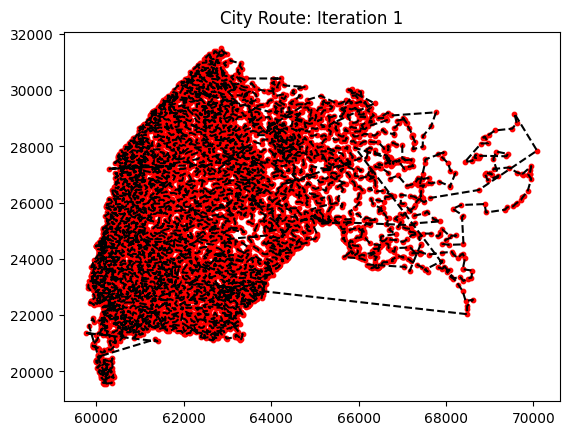

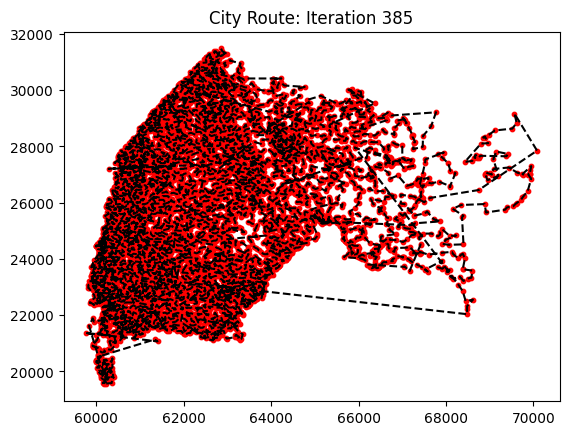

Iteration 1000
Execution Time: 58.02457809448242
Path: [0, 74, 207, 424, 550, 616, 683, 684, 739, 777, 778, 779, 836, 686, 617, 685, 682, 932, 931, 1067, 1066, 1065, 930, 980, 1021, 1235, 1236, 1285, 1237, 1157, 1325, 1538, 1721, 1628, 1491, 1492, 1442, 1586, 1587, 1679, 1588, 1493, 1443, 1494, 1539, 1589, 1723, 1724, 1725, 1816, 1817, 1764, 1680, 1630, 1590, 1591, 1542, 1446, 1541, 1540, 1445, 1629, 1815, 1893, 1937, 1975, 1938, 1939, 1894, 1940, 2087, 2220, 2267, 2266, 2348, 2399, 2400, 2349, 2300, 2299, 2350, 2351, 2456, 2455, 2499, 2546, 2592, 2591, 2545, 2454, 2498, 2636, 2678, 2730, 2826, 2776, 2876, 3038, 3139, 3191, 3226, 3263, 3336, 3402, 3403, 3372, 3435, 3404, 3373, 3302, 3141, 3089, 2995, 3140, 3264, 3371, 3401, 3370, 3335, 3334, 3300, 3225, 3189, 3224, 3262, 3299, 3190, 3138, 3037, 2994, 2875, 2874, 2993, 2992, 3036, 3088, 2922, 2825, 2873, 2991, 2775, 2728, 2676, 2634, 2541, 2495, 2494, 2493, 2540, 2492, 2450, 2395, 2396, 2342, 2343, 2344, 2345, 2346, 2397, 2452, 2453, 23

In [42]:
# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()

best_path, best_cost = ga(coord_list)

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))

In [17]:
file_path = 'tsplib/gr9882.tsp'

Start Genetic Algorithm
Initialize the population
Path 0 is initialized
Path 1 is initialized
Path 2 is initialized
Path 3 is initialized
Start the evolution


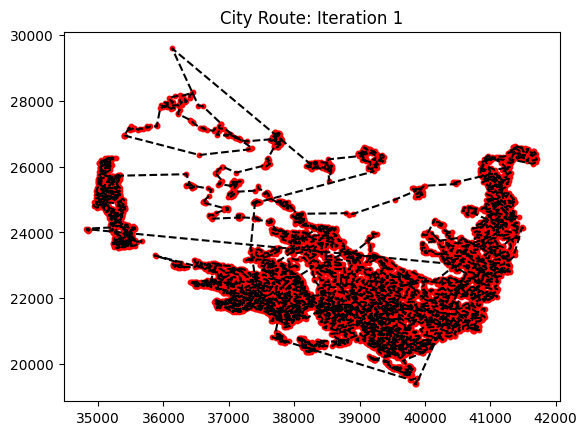

Iteration 1000


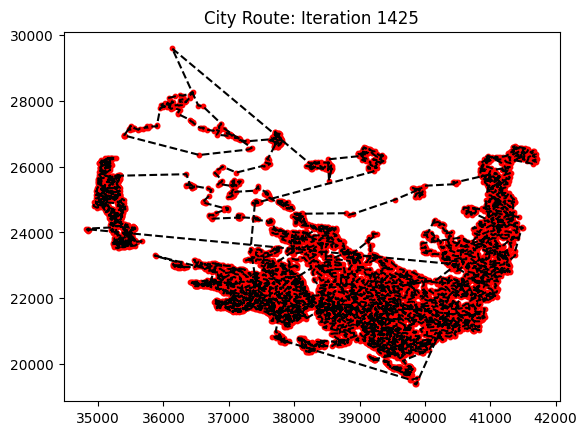

Execution Time: 58.02545213699341
Path: [0, 1, 3, 5, 2, 4, 381, 382, 426, 427, 428, 466, 504, 505, 429, 384, 385, 386, 467, 508, 507, 506, 547, 546, 628, 678, 679, 723, 724, 680, 629, 589, 549, 548, 588, 590, 591, 631, 630, 632, 633, 592, 550, 509, 510, 470, 471, 430, 392, 391, 390, 345, 310, 311, 312, 346, 347, 313, 348, 393, 349, 314, 247, 215, 280, 248, 281, 350, 351, 396, 435, 436, 476, 437, 352, 316, 315, 282, 283, 249, 216, 217, 188, 121, 147, 187, 284, 285, 286, 317, 287, 288, 250, 218, 189, 190, 149, 123, 124, 150, 151, 152, 126, 125, 94, 47, 46, 45, 93, 92, 91, 122, 148, 219, 220, 251, 252, 221, 222, 223, 253, 254, 255, 224, 193, 192, 154, 127, 153, 95, 69, 48, 30, 16, 9, 10, 17, 18, 19, 11, 31, 32, 52, 53, 54, 33, 34, 20, 21, 22, 23, 13, 24, 25, 26, 27, 35, 36, 75, 103, 104, 76, 77, 105, 78, 79, 106, 58, 59, 60, 80, 81, 61, 40, 82, 108, 109, 83, 62, 41, 170, 207, 269, 330, 367, 368, 418, 417, 416, 453, 454, 491, 535, 534, 533, 532, 531, 490, 452, 414, 365, 366, 415, 300, 299,

In [18]:
# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()

best_path, best_cost = ga(coord_list)

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))

### 대규모 데이터 TSP를 GA로 해결하기 위해, 경로의 길이를 단축시키는 방법을 활용한다. 특정 구간의 경로가 Path Pool에 있는 모든 Solution에서 동일하게 발견될 때, 이를 하나의 값으로 압축시켜서 시간 복잡도를 줄이는 방법을 택했다. 다만 경로가 기하급수적으로 압축되는 것을 방지하기 위해, Path의 길이가 작아질 수록 공통 경로가 압축될 확률을 줄여나간다.  또한, Population을 초기화하는 과정에서 랜덤하게 경로를 구축하지 않고, 'An Effective Genetic Algorithm for Large-Scale Traveling Salesman Problems'[1] 논문에서 제안한 Chromosome Generation 방법을 이용하여 Initial Population을 구성한다. 해당 방법은 시간 소요가 약간 있는 방법인데, 초기화에 대부분의 시간을 소요할 수는 없으므로, Initial Generation의 Pool Size는 매우 작은 값으로 설정한 뒤, 몇 번의 Generation을 거쳐서 설정한 최대 Pool Size에 도달하는 방법을 사용한다.

[1] SD Dao, K Abhary, R Marian, An Effective Genetic Algorithm for Large-Scale Traveling Salesman Problems, Proceedings of the World Congress on Engineering and Computer Science, 2016, Vol I